## Credit Risk Analysis Prediction:
- '0' status presenting no risk and loan will be repaid on time
- On the other hand, '1' indicating that the loan presents a risk and the client will have some payment difficulties.

**Import necessary Libraries:**

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score

In [2]:
data = pd.read_csv(r'C:\Users\91842\Downloads\German Credit Data.csv')
data.head()

,checkin_acc,duration,credit_history,amount,savings_acc,present_emp_since,inst_rate,personal_status,residing_since,age,inst_plans,num_credits,job,status
0,A11,6,A34,1169,A65,A75,4,A93,4,67,A143,2,A173,0
1,A12,48,A32,5951,A61,A73,2,A92,2,22,A143,1,A173,1
2,A14,12,A34,2096,A61,A74,2,A93,3,49,A143,1,A172,0
3,A11,42,A32,7882,A61,A74,2,A93,4,45,A143,1,A173,0
4,A11,24,A33,4870,A61,A73,3,A93,4,53,A143,2,A173,1


In [3]:
data['status'].value_counts()

0    700
1    300
Name: status, dtype: int64

In [4]:
data.shape

(1000, 14)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   checkin_acc        1000 non-null   object
 1   duration           1000 non-null   int64 
 2   credit_history     1000 non-null   object
 3   amount             1000 non-null   int64 
 4   savings_acc        1000 non-null   object
 5   present_emp_since  1000 non-null   object
 6   inst_rate          1000 non-null   int64 
 7   personal_status    1000 non-null   object
 8   residing_since     1000 non-null   int64 
 9   age                1000 non-null   int64 
 10  inst_plans         1000 non-null   object
 11  num_credits        1000 non-null   int64 
 12  job                1000 non-null   object
 13  status             1000 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 109.5+ KB


- Out of total 14 features 7 are categorical and rest are numerical.

In [31]:
data['job'].value_counts()

A173    630
A172    200
A174    148
A171     22
Name: job, dtype: int64

**EDA: Now that we have the data, let's understand the data before attempting to model it:**

Few of the questions to ask based on the available data:
- Check the correlation among the input variables?
- Is there any relation present between the input variables and the output variable, status?
- If there is such relation existing then how strong is the relation?
- Identify the probable useful features? 
- What purpose of the loans are more risk to business? Is there any pattern hidden in the data that can give evidence of this?
- Can risk be associated with the credit amount? If yes, then how is the association type?

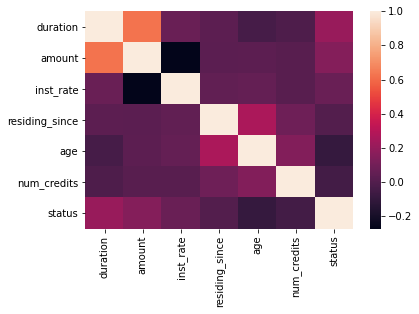

In [33]:
# let's check the correlation matrix of the numerical features:
sns.heatmap(data.corr());

Observation:
- From the heatmap it seems that credit amonut has a strong negative correlation with interest rate
- And amount has a moderate positive correlation with duration. If the credit amount is high then the duration to pay it will also be high.

**1. Let's do chi2 test to establish the claim - credit_history & status may be related**

In [7]:
# Contingency Table 
tab = pd.crosstab(data['credit_history'], data['status'])
chi2, p, dof, exp = chi2_contingency(tab)

#check the p-value of the test:
if p<0.05:
    print('Reject the Null hypothesis')
    print('There is a relation between credit_history & status')
else:
    print('Do not reject the Null hypothesis')
    print('There is no relation between credit_history & status')

Reject the Null hypothesis
There is a relation between credit_history & status


C:\Users\91842\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


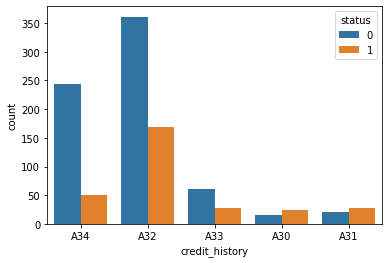

In [8]:
sns.countplot(data['credit_history'], hue=data['status']);

Observation:
- It is quite evident from the graph that customers who has taken the loan for the 1st time (A30) from this bank are more likley to be 'Bad Credit'.
- Whereas, for customers whose existing credits are paid back duly till now (A32) are less likely to be 'Bad credit'.
- Similarly, customers with credits existing from other bank (A34) are less likely to be 'Bad credit'.

**2. Let's check if Loan Duration & status is related or not:**
- First descretize the duration column into categories:

In [9]:
# create a list of our conditions
conditions = [
    (data['duration'] == 12),
    (data['duration'] >12),
    (data['duration'] <12)]

# create a list of the values we want to assign for each condition
values = ['1 year', 'More than 1 year', 'Less than 1 year']

# create a new column and use np.select to assign values to it using our lists as arguments
data['duration_new'] = np.select(conditions, values, 'Other duration')

# display updated DataFrame
data['duration_new'][:3]

0    Less than 1 year
1    More than 1 year
2              1 year
Name: duration_new, dtype: object

C:\Users\91842\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


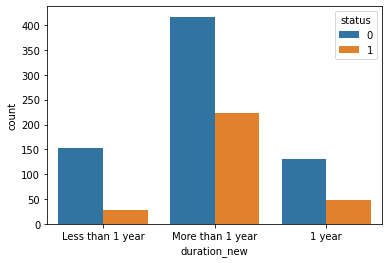

In [10]:
sns.countplot(data['duration_new'], hue=data['status']);

Observation:
- The customers have Bad credit history where the loan duration is more tha 1 year. 
- Less than 1 year loans are being paid on time in comparison to the loans which are taken for longer duration.
- And most of the loans are taken for more than 1 year period from this bank.

**3. Can loan amount be a risk factor for loan re-paymnet:**

<AxesSubplot:xlabel='status', ylabel='amount'>

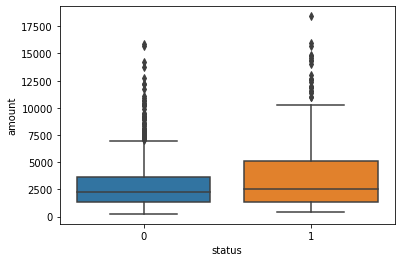

In [11]:
sns.boxplot(x="status", y="amount", data=data)

Observation:
- It seems that the 75% of the Bad credit loan amount is below 5500.
- Whereas, for Good credit the 75% of the loan amount is less than 3750.
- And for this bank the highest taken loan amount (>17500) has turned out to be a Bad credit.
- So, higher the loan amount higher may be the risk.

**4. Let's check what is the credit status looks for such very high loan amount:**

- At first performed Outlier detection for loan amount:

In [12]:
Q1 = np.quantile(data['amount'],0.25)
Q3 = np.quantile(data['amount'],0.75)
Extreme_Q1 = Q1-3*(Q3-Q1) 
Extreme_Q3 = Q3+3*(Q3-Q1)
outlier_loan_amount = data[data['amount']>Extreme_Q3]
(outlier_loan_amount['status'].value_counts()/outlier_loan_amount.shape[0])*100

1    70.833333
0    29.166667
Name: status, dtype: float64

Observation:
- From the baove data it is evident that out of these extreme high loan maount approximately 71% have turned out as 'Bad Credit' and only 29% are 'Good Credit'
- With no surprise we can say that high loan amount is a high risk.

**5. Let's check if Present employment plays any role in the loan status:**

<AxesSubplot:xlabel='present_emp_since'>

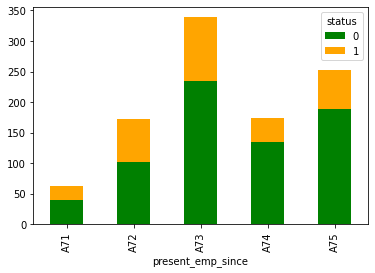

In [13]:
var = data.groupby(['present_emp_since','status']).status.count()
var.unstack().plot(kind='bar',stacked=True,  color=['green','orange'], grid=False)

Observation:
- 'A73' are the customers with current experice between 1 to 4 years and 'A72' are the customers with current experice <1 year. They are the most likely to turn out as 'Bad Credit' in comparison to others. 
- The bank has also approved loans to such customers who are currently unemployed ('A71') but they are very less in numbers.
- Also it is clear from the graph that customers irrespective of their present employment status have turned as 'Bad Credit'. There is no particula pattern present here.

**6. Let's check the loan amount for all the categries under present employment status**: 

In [14]:
data.groupby(['present_emp_since','status']).agg({'status':'count','amount':'mean'})

status       amount
present_emp_since status                     
A71               0           39  4192.820513
                  1           23  4257.347826
A72               0          102  2683.539216
                  1           70  3344.300000
A73               0          235  2770.000000
                  1          104  3928.096154
A74               0          135  3478.755556
                  1           39  4027.256410
A75               0          189  2814.798942
                  1           64  4434.890625

Observatio:
- It is evident that with with increase in the number of empleoyment years there is increse in the average loan amount.
- In each employment category, the average loan amount is high for 'Bad Credit' than the 'Good Credit' average loan amount.

**7. Installment rate vs status:**

<AxesSubplot:xlabel='inst_rate'>

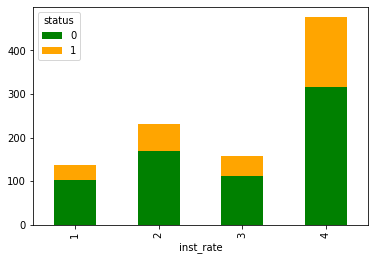

In [15]:
var = data.groupby(['inst_rate','status']).status.count()
var.unstack().plot(kind='bar',stacked=True,  color=['green','orange'], grid=False)

Observation:
- The customers who are paying 4% installment rate are more likle to be turn out as 'Bad Credit'.
- Lowest rate (1%) has the lowest chance of being 'Bad Credit'.

**8. Let's look at the personal deatils of the customers and if there is any hidden pattern present in it:**

In [16]:
(data['personal_status'].value_counts()/data.shape[0])*100

A93    54.8
A92    31.0
A94     9.2
A91     5.0
Name: personal_status, dtype: float64

C:\Users\91842\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


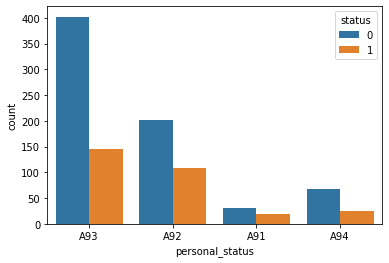

In [17]:
sns.countplot(data['personal_status'], hue=data['status']);

Observations:
- 50% of the loan borrowers are male who are single , i.e 'A93'. And it seems they are most likely to become 'Bad credit'
- And 30% of the loan borrowers are male who are divorced/separated/married , i.e 'A92'. 

**9. age vs status:**

<AxesSubplot:xlabel='status', ylabel='age'>

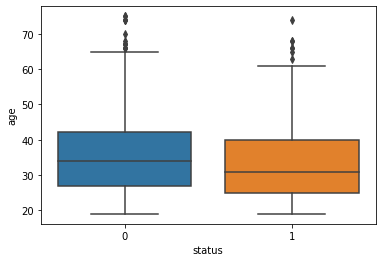

In [18]:
sns.boxplot(x="status", y="age", data=data)

Observation:
- 'age' variable shows that the median value for 'Bad credit' is lesser than the 'Good credit'. Which indicates 50% of the 'Bad credit' customers are young than the 50% of the 'Good credit' customers.
- So, 'age' may be considered a risk factor.

**Conclusion based on EDA:**
Performed descriptive stats on some of the numeric variables like duration of loan, age of the customers and credit amount. Also, performaed cross-tabulation and chi2 test of independence for some of the categorical varaibles like credit history of the customers.
- Now tha analysis reveals that loan duration has a relation with loan re-payment status. Higher the duration indicates more risk correlating to 'Bad credit'.
- Not surprisingly, lower the age of the lonee higher the risk. 
- Analysis reveals that single males tend to borrow more, and as before, younger they are higher the risk.
- Loan amount is evidently related to the risk. As expected, higher loan amount corresponds to a 'Bad credit'.
- Surprisingly, irrespective of the current employment status customers may be turned as a 'Bad credit'. 

**Data preprocessing:** 

In [74]:
x_features = list(data.columns)
x_features.remove('status')
x_features

['checkin_acc',
 'duration',
 'credit_history',
 'amount',
 'savings_acc',
 'present_emp_since',
 'inst_rate',
 'personal_status',
 'residing_since',
 'age',
 'inst_plans',
 'num_credits',
 'job',
 'duration_new']

- Convert the categorical variables into numerical variables:

In [75]:
encoded_data = pd.get_dummies(data[x_features], drop_first=True)
encoded_data.shape

(1000, 31)

In [76]:
y = data['status']
X = encoded_data

- Scale the data:

In [77]:
scalar = RobustScaler()
X_scaled = scalar.fit_transform(X)

In [78]:
#splitting the data into trainig set and testing set
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y = train_test_split(X_scaled,y,train_size=0.8,stratify=y)

**Model building: Now that data pre-processing is done, let's proceed with model building**

Process Followed:
- The risk prediction is a standard supervised classification real-time problem. So, applied supervised learning approach for the modelling.
- The labels are included in the training data and the goal is to train a model to learn to predict the labels from the features given to it.
- Here the label is a binary variable, 0 ('Good credit' indicating no risk and loan will be paid on time), 1 ('Bad credit' indicating risk and hence difficulty repaying loan).
- Used Logistic Regression and Tree based modelling.
- At first created the baseline models. 
- Out of all the baseline models whichever meets the objective of this project will be tuned further in order to seek the best hyperparameters and to improve the model's predictive power.

- Selected tree based models for this particular dataset and the problem statment. As tree based models are not affected by outliers. We have detected outliers in the data. 
- Also, there is a suspect of multi-collinearity among the independent variables like between - age and Present employment status, loam amount and interest rate, amount and duration. Hence, Tree based algorithm can be a good choice in this case.

Logistic Regression:

In [79]:
#create an instance
LR_clf = LogisticRegression()

#fit the train data to the model
LR_clf.fit(train_x, train_y)

#predict using test set
y_pred_LR = LR_clf.predict(test_x)

#check the accuracy of the model
cm = confusion_matrix(test_y, y_pred_LR)
print('The confusin matrix:\n', cm)
print('The overall report:\n', classification_report(test_y, y_pred_LR))

The confusin matrix:
 [[129  11]
 [ 33  27]]
The overall report:
               precision    recall  f1-score   support

           0       0.80      0.92      0.85       140
           1       0.71      0.45      0.55        60

    accuracy                           0.78       200
   macro avg       0.75      0.69      0.70       200
weighted avg       0.77      0.78      0.76       200



In [25]:
#predict using the test set:
LR_clf.predict_proba(test_x)[:5]

array([[0.55978446, 0.44021554],
       [0.35325784, 0.64674216],
       [0.59471735, 0.40528265],
       [0.45340582, 0.54659418],
       [0.54447654, 0.45552346]])

In [26]:
#store the predicted probabilites into a dataframe:
proba_df = pd.DataFrame({"Actual Data":test_y,
                      "Predctied_Probability_Good Credit":LR_clf.predict_proba(test_x)[:,0],
                      "Predctied_Probability_Bad Credit":LR_clf.predict_proba(test_x)[:,1]})
proba_df.head(10)

,Actual Data,Predctied_Probability_Good Credit,Predctied_Probability_Bad Credit
392,0,0.559784,0.440216
831,1,0.353258,0.646742
691,0,0.594717,0.405283
83,0,0.453406,0.546594
14,0,0.544477,0.455523
843,0,0.793515,0.206485
539,0,0.719215,0.280785
621,1,0.899020,0.100980
99,0,0.664947,0.335053
698,0,0.902306,0.097694


Observation based on results:
- It seems the Logistic regression is not performing very well to correctly predict the 'Bad credit', and hence the Recall for this class is very low (45%)
- But the Precision is also not very high, 71%. Which means out of all the predicted 'Bad Credit' 71% are the actually 'Bad credit'. 
- As a result F1-Score is also low.
- But the model's overall accuracy is not very poor, 78%. 

Decision Tree:

In [82]:
#create an instance
dt_clf = DecisionTreeClassifier()

#fit the train data to the model
dt_clf.fit(train_x, train_y)

#predict using test set
y_pred_dt = dt_clf.predict(test_x)

#check the accuracy of the model
cm = confusion_matrix(test_y, y_pred_dt)
print('The confusin matrix:\n', cm)
print('The overall report:\n', classification_report(test_y, y_pred_dt))

The confusin matrix:
 [[108  32]
 [ 20  40]]
The overall report:
               precision    recall  f1-score   support

           0       0.84      0.77      0.81       140
           1       0.56      0.67      0.61        60

    accuracy                           0.74       200
   macro avg       0.70      0.72      0.71       200
weighted avg       0.76      0.74      0.75       200



- The decision tree model is able to rightly classify 74% of the data.
- 67% of the 'Bad credit' is being correctly predicted by the model, which is not a bad figure for this data.
- And the F1-Score is also good.

Random Forest Model:

In [86]:
rf_model = BaggingClassifier(base_estimator=RandomForestClassifier(),
                            bootstrap=True,
                            oob_score=True)

#fit the train data to the bagging model
rf_model.fit(train_x, train_y)

#predict using test set
y_predictions_rf = rf_model.predict(test_x)

#check the accuracy of the model
print(classification_report(test_y, y_predictions_rf))

              precision    recall  f1-score   support

           0       0.77      0.94      0.85       140
           1       0.72      0.35      0.47        60

    accuracy                           0.77       200
   macro avg       0.75      0.65      0.66       200
weighted avg       0.76      0.77      0.74       200



C:\Users\91842\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:640: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\91842\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:645: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


- Random forest model is able to predict correctly 77% of the data.
- Now let's try to improve the model accuracy by tuning the hyperparamter

In [34]:
model2 = RandomForestClassifier()

# we are tuning with 3 hyperparameters, we are passing the different values for the parameters
grid_param = {"n_estimators" : [90,100,115,130],
    'criterion': ['gini', 'entropy'],
    'max_depth' : range(2,8),
    'min_samples_leaf' : range(1,8),
    'min_samples_split': range(2,8),
    'max_features' : ['auto','log2']}

cv = GridSearchCV(estimator=model2,
                     param_grid=grid_param,
                     cv=5,
                    scoring='accuracy')

cv.fit(train_x,train_y)
print(cv.best_params_)

{'criterion': 'entropy', 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 100}


In [95]:
# Create new model using the above received best parameters
rf_model2 = BaggingClassifier(base_estimator=RandomForestClassifier(n_estimators=120,
                                           criterion='entropy',
                                           max_depth=7,
                                           min_samples_leaf=2,
                                           min_samples_split=8),
                            bootstrap=True,
                            oob_score=True)

#fit the train data to the bagging model
rf_model2.fit(train_x, train_y)

#predict using test set
y_predictions_rf2 = rf_model2.predict(test_x)

#check the accuracy of the model
print(classification_report(test_y, y_predictions_rf2))

              precision    recall  f1-score   support

           0       0.75      0.97      0.85       140
           1       0.79      0.25      0.38        60

    accuracy                           0.76       200
   macro avg       0.77      0.61      0.61       200
weighted avg       0.76      0.76      0.71       200



C:\Users\91842\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:640: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\91842\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:645: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


- So, even after performing hyper parameter tuning also there is no improvement in the model's accuracy

XGBoost:

In [90]:
# fit model no training data
xgb = XGBClassifier()
xgb.fit(train_x, train_y)

# cheking training accuracy
y_predictions_xgb = xgb.predict(test_x)

#check the accuracy of the model
print(classification_report(test_y, y_predictions_xgb))

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       140
           1       0.64      0.45      0.53        60

    accuracy                           0.76       200
   macro avg       0.72      0.67      0.68       200
weighted avg       0.75      0.76      0.75       200



- XGBoost model's accuracy is 76%
- Recall is very low, 45%. And hence F1-Score is also not very good.

Model Selection: ROC-AUC

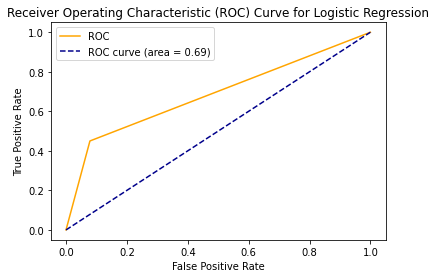

In [92]:
# Area Under Curve
auc = roc_auc_score(test_y, y_pred_LR)

# ROC
fpr_random, tpr_random, thresholds_radom = roc_curve(test_y, y_pred_LR)

# Plotting ROC for Random Forest
plt.plot(fpr_random, tpr_random, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='ROC curve (area = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Logistic Regression')
plt.legend()
plt.show()

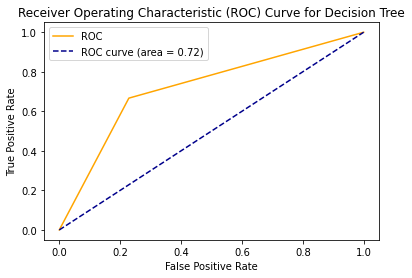

In [83]:
# Area Under Curve
auc = roc_auc_score(test_y, y_pred_dt)

# ROC
fpr_random, tpr_random, thresholds_radom = roc_curve(test_y, y_pred_dt)

# Plotting ROC for Random Forest
plt.plot(fpr_random, tpr_random, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='ROC curve (area = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Decision Tree')
plt.legend()
plt.show()

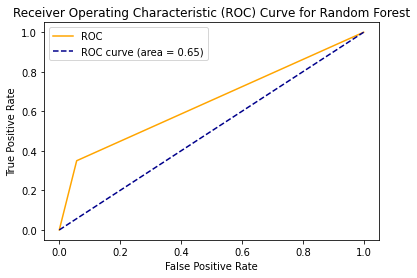

In [88]:
# Area Under Curve
auc = roc_auc_score(test_y, y_predictions_rf)

# ROC
fpr_random, tpr_random, thresholds_radom = roc_curve(test_y, y_predictions_rf)

# Plotting ROC for Random Forest
plt.plot(fpr_random, tpr_random, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='ROC curve (area = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest')
plt.legend()
plt.show()

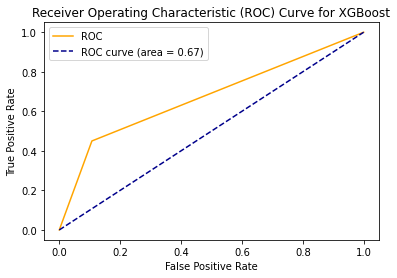

In [91]:
# Area Under Curve
auc = roc_auc_score(test_y, y_predictions_xgb)

# ROC
fpr_random, tpr_random, thresholds_radom = roc_curve(test_y, y_predictions_xgb)

# Plotting ROC for Random Forest
plt.plot(fpr_random, tpr_random, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='ROC curve (area = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for XGBoost')
plt.legend()
plt.show()